In [1]:
import os
import pandas as pd
import json
import seaborn as sns
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)

file_to_compare = ExperimentFiles.ALL_TOOLS_MCP_SEQ

# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(notebook_dir, "..", "results", "experiments")

dfs = []
all_llm_folders = list(ExperimentFolders)

for folder in all_llm_folders:
    path = os.path.join(base_experiment_dir, folder, file_to_compare)
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        dfs.append(df)
    except Exception as e:
        print(f"Failed to load {folder}/{file_to_compare}: {e}")

df = pd.concat(dfs, ignore_index=True)

# Now you can compare/filter by experiment_name
print(df["model_used"].value_counts())

model_used
gpt-4.1             91
o3                  91
gemini-2.0-flash    91
Name: count, dtype: int64


In [3]:
# Map raw experiment names directly to single-letter codes
name_map = {
    "gemini-2.0-flash": "G20F",
    "gpt-4.1": "GPT41",
    "o3": "O3",
}
df["model_used"] = df["model_used"].map(name_map)

df = df.sort_values(by="model_used")

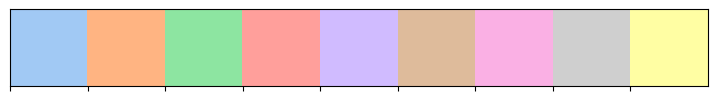

In [4]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

# Direct Fact Score

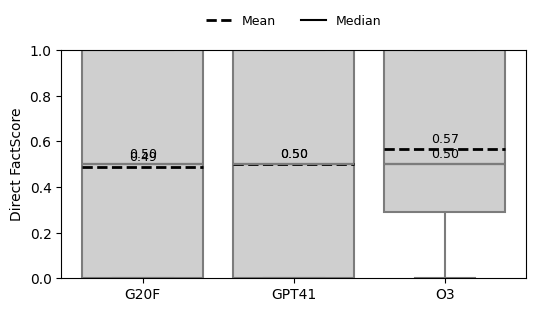

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(6, 4))

# Draw boxplot
ax = sns.boxplot(
    data=df,
    x="model_used",
    y="fact_score.direct_fact_score",
    color=my_palette[7],
    showfliers=False,
    linewidth=1.5,
)

# X-tick metadata
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute stats
means = df.groupby("model_used")["fact_score.direct_fact_score"].mean()
medians = df.groupby("model_used")["fact_score.direct_fact_score"].median()
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay lines + annotations
for experiment, pos in pos_map.items():
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        plt.hlines(
            mean_val, pos - 0.4, pos + 0.4, colors="black", linestyles="--", linewidth=2
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        plt.hlines(
            median_val,
            pos - 0.4,
            pos + 0.4,
            colors="black",
            linestyles="-",
            linewidth=1.5,
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final styling
plt.xlabel("")
plt.ylabel("Direct FactScore")
plt.ylim(0, 1)

# Top-centered legend without frame
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=9,
    frameon=False,
    ncol=2,
)

# Add margin for legend
plt.subplots_adjust(top=0.82, bottom=0.25)
plt.show()

# Agent as a judge outcome

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_46394/728124138.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stacked_percent.index)


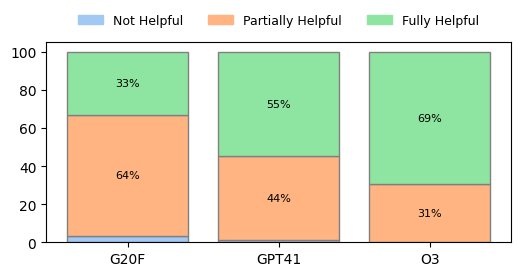

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group and count
stacked_data = (
    df.groupby(["model_used", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Convert to percentages row-wise
stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bottom = [0] * len(stacked_percent)

for idx, outcome in enumerate(desired_order):
    values = stacked_percent[outcome].values
    bars = ax.bar(
        stacked_percent.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate with percent labels (skip small segments)
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val >= 5:
            ax.text(
                i,
                btm + val / 2,
                f"{val:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

    bottom = [btm + val for btm, val in zip(bottom, values)]

# X-axis labels
ax.set_xticklabels(stacked_percent.index)

# Legend near top edge
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=my_palette[i], label=label)
    for i, label in enumerate(desired_order)
]
ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9,
    frameon=False,
    ncol=len(legend_handles),
)

# Adjust layout to fit tighter to legend
fig.subplots_adjust(top=0.75, bottom=0.25)
plt.show()

# Token Consumption

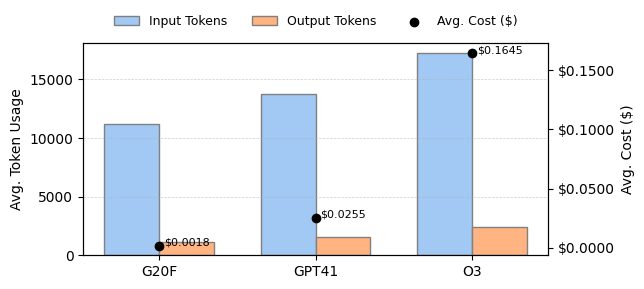

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns

# -- Preprocess as before --

inverted_model_map = {v: k for k, v in name_map.items()}


# Token usage per model
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
]
mean_token_usage = df.groupby("model_used")[token_cols].mean().reset_index()

# Cost per model
from experiments.interpretation.interpretation_util import ModelPricing

grouped = df.groupby("model_used")
agent_costs = {
    model: (
        (group["tokens_consumed.input_tokens"].mean() / 1000)
        * ModelPricing[inverted_model_map[model]]["input"]
        + (group["tokens_consumed.output_tokens"].mean() / 1000)
        * ModelPricing[inverted_model_map[model]]["output"]
    )
    for model, group in grouped
}

# -- Create figure --
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot token usage (stacked bars: input + output)
x = mean_token_usage["model_used"]
input_tokens = mean_token_usage["tokens_consumed.input_tokens"]
output_tokens = mean_token_usage["tokens_consumed.output_tokens"]

bar_width = 0.35
x = mean_token_usage["model_used"]
x_pos = range(len(x))

bar1 = ax1.bar(
    [i - bar_width / 2 for i in x_pos],
    input_tokens,
    width=bar_width,
    color=my_palette[0],
    edgecolor="gray",
    label="Input Tokens",
)

bar2 = ax1.bar(
    [i + bar_width / 2 for i in x_pos],
    output_tokens,
    width=bar_width,
    color=my_palette[1],
    edgecolor="gray",
    label="Output Tokens",
)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)
ax1.set_ylabel("Avg. Token Usage")
ax1.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Plot cost using a secondary y-axis
ax2 = ax1.twinx()
costs = [agent_costs[exp] for exp in x]
line = ax2.scatter(
    x_pos,
    costs,
    color="black",
    marker="o",
    label="Avg. Cost ($)",
)

ax2.set_ylabel("Avg. Cost ($)")
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.4f}"))

# Annotate cost
for i, cost in enumerate(costs):
    ax2.annotate(
        f"${cost:.4f}",
        (i, cost),
        textcoords="offset points",
        xytext=(20, 0),
        ha="center",
        fontsize=8,
        color="black",
    )

# Combine legends
token_legend = [
    Patch(facecolor=my_palette[0], edgecolor="gray", label="Input Tokens"),
    Patch(facecolor=my_palette[1], edgecolor="gray", label="Output Tokens"),
]
all_handles = token_legend + [line]

# Legend above the plot
ax1.legend(
    handles=all_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9,
    frameon=False,
    ncol=len(all_handles),
)

# Adjust layout to accommodate legend above
fig.subplots_adjust(top=0.78, bottom=0.25)
plt.show()

# BERT Score

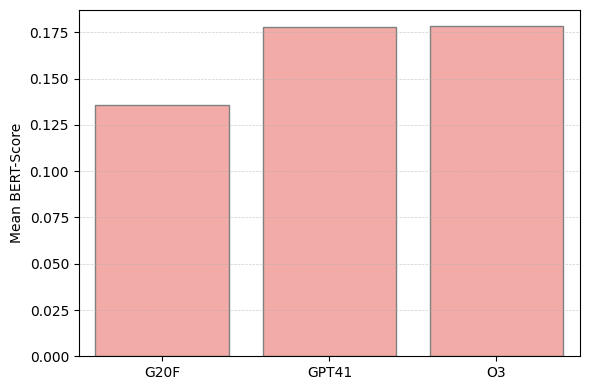

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["model_used"].unique()

# Compute mean BERT score per experiment
mean_bert = df.groupby("model_used")["bert_score"].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=mean_bert,
    x="model_used",
    y="bert_score",
    order=experiment_order,
    color=my_palette[3],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Mean BERT-Score")
plt.tight_layout()
plt.show()

# Tool Calls

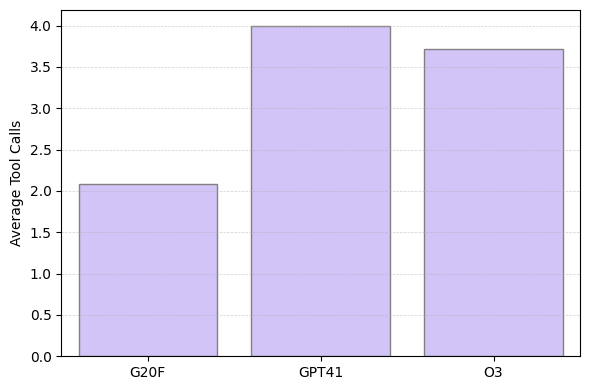

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["model_used"].unique()

# Compute mean tool calls per experiment
mean_tools = df.groupby("model_used")["tool_calls_count"].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=mean_tools,
    x="model_used",
    y="tool_calls_count",
    order=experiment_order,
    color=my_palette[4],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Average Tool Calls")
plt.tight_layout()
plt.show()

# Time Consumed

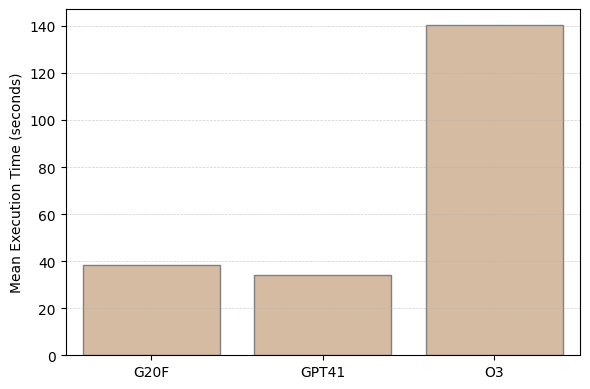

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by configuration (experiment_name), compute mean execution time
grouped = df.groupby("model_used")["excecution_time_seconds"].mean().reset_index()


# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=grouped,
    x="model_used",
    y="excecution_time_seconds",
    color=my_palette[5],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.ylabel("Mean Execution Time (seconds)")
plt.xlabel("")
plt.tight_layout()
plt.show()